# PyESAPI: Getting Started
*By Michael Folkerts*  
*<mailto:Michael.Folkerts@varian.com>*

We assume `pip install git+https://github.com/VarianAPIs/PyESAPI` has already been executed in your conda3 environment.
## Import PyESAPI
* Create one instance of the eclipse scripting application
* Set the script name for logging purposes to "python_demo"
* Regester the application disposal fumctopm at exit (avoids unexpected exit/crash of app instance)

In [1]:
import pyesapi
import atexit
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')
atexit.register(app.Dispose);

## Find a Patient
* List patient Ids
* Open a patient
* Print patient info
* Python 3.6 f-string sugar

In [2]:
for pat_sum in app.PatientSummaries:
    print(pat_sum.Id)

ref brain
connie breast pt
191001
TestUpperBody
HeartDVHErrorV35Gycc


In [3]:
patient = app.OpenPatientById('TestUpperBody')

In [4]:
print('Name: {patient.FirstName}, LastName: {patient.LastName}'.format(**locals()))

Name: Blueberry, LastName: Pizza


In [5]:
print(f'Name: {patient.FirstName}, LastName: {patient.LastName}')

Name: Blueberry, LastName: Pizza


## A little about Lots
* Create an array with pythonnet collection iterator
* Demo the PyESAPI Lot
  * Indexing
  * Constructor Shortcuts
  * Constructor Select
  * Lot.FirstOrDefault

In [6]:
[c.Id for c in patient.Courses] # python list comprehension on pythonnet collection iterator

['C1']

### <a href="https://www.google.com/search?q=define+lot">Lot</a>
*noun*  
1.  
*informal*  
a particular group, collection, or set of people or things.  
*"it's just one lot of rich people stealing from another"*

In [7]:
patient.CoursesLot() # "Lot" a custom PyESAPI collection wrapper class

In [8]:
patient.CoursesLot()[0].Id # Indexable after construction

'C1'

In [9]:
patient.CoursesLot(0).Id # Indexable at construction

'C1'

In [10]:
patient.CoursesLot('C1').Id # passing string will match Id

'C1'

In [11]:
patient.CoursesLot(lambda c: c.Id == 'C1').Id # passing function acts like "first or default"

'C1'

In [12]:
patient.CoursesLot().FirstOrDefault(lambda c: c.Id == 'C1').Id

'C1'

## Open a Plan
* Print plan info
* Print structure info
* Print beam info

In [13]:
plan = patient.CoursesLot('C1').PlanSetupsLot(0)

In [14]:
print(f'Plan Id: {plan.Id}')
print(f'Dose Per Fx: {plan.PrescribedDosePerFraction}')
print(f'Number of Fx: {plan.NumberOfFractions}')

Plan Id: IMRT
Dose Per Fx: 2000.0 cGy
Number of Fx: 30


In [15]:
print(f'TYPE,ID,VOLUME')
for structure in plan.StructureSet.Structures:
    print(f'{structure.DicomType},{structure.Id},{structure.Volume:.2f}')

TYPE,ID,VOLUME
PTV,Heart,66.71
EXTERNAL,BODY,9515.75
AVOIDANCE,R Lung,939.14
AVOIDANCE,L Lung,760.37
ORGAN,Cord,39.26
AVOIDANCE,Total Lung,1705.62
PTV,Lg Tumor,825.51


In [16]:
print(f'ID,SSD,Mu,Angle')
for beam in plan.Beams:
    print(f'{beam.Id},{beam.SSD:.2f},{beam.Meterset.Value:.2f},{beam.ControlPoints[0].GantryAngle}')

ID,SSD,Mu,Angle
Field 1,885.74,95.03,315.0
Field 2,867.56,99.98,45.0
Field 3,895.86,99.98,135.0
Field 4,898.13,101.96,225.0


## Plotting
* Get CT Image as 3D Numpy Array
* Print CT properties
* Plot a CT slice
* Get dose at CT resolution
* Plot Dose slice
* Get structure mask
* Plot dose in structure
* Plot dose on CT slice (cropped and zoomed)
* **Extra Credit:** Overlay all dose above a given value

In [17]:
ct_image = plan.StructureSet.Image.np_array_like() # an actual numpy array

In [18]:
type(ct_image)

numpy.ndarray

In [19]:
ct_image.shape # indexed like x, y, z

(512, 512, 237)

In [20]:
import matplotlib.pyplot as plt
slice_num = 110
plt.imshow(ct_image[:,:,slice_num].T, cmap='gray')
plt.show()

In [21]:
dose = plan.Dose.np_array_like(plan.StructureSet.Image) # create dose at CT resolution

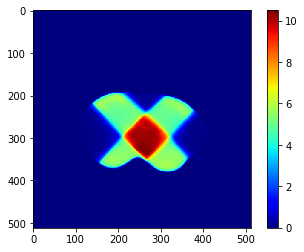

In [22]:
plt.imshow(dose[:,:,slice_num].T,cmap='jet')
plt.colorbar()
plt.show()

In [23]:
structure = plan.StructureSet.StructuresLot('Heart').np_mask_like(plan.StructureSet.Image)

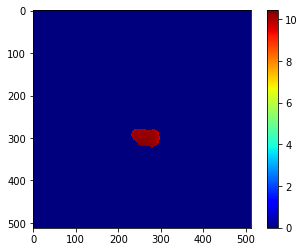

In [24]:
import numpy as np
dose_in_structure = dose*structure
plt.imshow(dose_in_structure[:,:,slice_num].T, cmap='jet')
plt.colorbar()
plt.show()

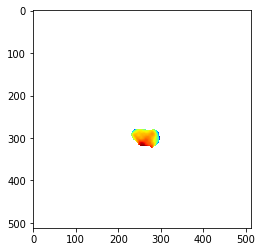

In [25]:
non_zero_dose_in_structure = np.ma.masked_where(dose_in_structure==0,dose_in_structure)
plt.imshow(non_zero_dose_in_structure[:,:,slice_num].T, cmap='jet')
plt.show()

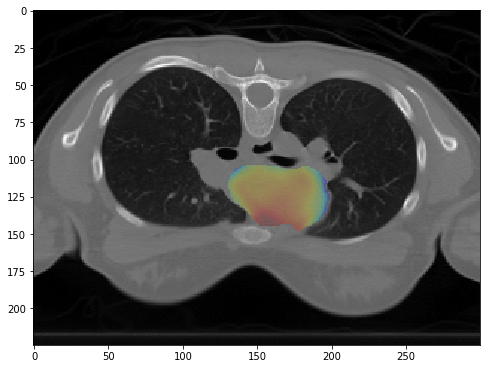

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(ct_image[100:400,175:400,110].T, cmap='gray')
plt.imshow(non_zero_dose_in_structure[100:400,175:400,110].T, cmap='jet',alpha=.25)
plt.show()

## Bonus Round
* Interactive slice viewer

In [27]:
from ipywidgets import interactive, widgets

def slice_plot_function(slider_num):
    plt.figure(figsize=(8,8))
    plt.imshow(ct_image[100:400,175:400,slider_num].T, cmap='gray')
    plt.plot()

int_slider = widgets.IntSlider(
    value=slice_num,
    min=0,
    max=ct_image.shape[2]-1,
    step=1,
    description='Slice Number',
    continuous_update=False,
)
    
interactive(slice_plot_function, slider_num=int_slider)

interactive(children=(IntSlider(value=110, continuous_update=False, description='Slice Number', max=236), Output()), _dom_classes=('widget-interact',))